# 3 Processing and Training Data<a id='2_Processing_and_Training_Data'></a>

## 3.1 Introduction<a id='2.1_Introduction'></a>

The goal of this step is to normalize and standardize all the features in your data, as well as create a validation set.

## 3.2 Imports<a id='1.2_Imports'></a>

In [1]:
# Import functions
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import os
import pickle
import datetime
from library.sb_utils import save_file
from sklearn import datasets,linear_model
from sklearn.linear_model import LinearRegression
from sklearn import __version__ as sklearn_version
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale, StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression

pd.options.display.max_columns = 1000

In [2]:
# Define my own functions
def rmse(y_true, y_pre):
    return (np.mean((y_pre-y_true)**2))**0.5

In [3]:
# Define global variables
hypertable = []

In [4]:
AFRICA_ISOCODES = ['DZA', 'AGO', 'BEN', 'BWA', 'BFA', 'BDI', 'CMR', 'CPV', 'CAF', 'TCD', 
               'COM', 'COG', 'COD', 'CIV', 'DJI', 'EGY', 'GNQ', 'ERI', 'ETH', 'GAB', 
               'GMB', 'GHA', 'GIN', 'GNB', 'KEN', 'LSO', 'LBR', 'LBY', 'MDG', 'MLI', 
               'MWI', 'MRT', 'MUS', 'MYT', 'MAR', 'MOZ', 'NAM', 'NER', 'NGA', 'REU', 
               'RWA', 'STP', 'SEN', 'SYC', 'SLE', 'SOM', 'ZAF', 'SSD', 'SDN', 'SWZ', 
               'TZA', 'TGO', 'TUN', 'UGA', 'ESH', 'ZMB', 'ZWE']
EUR_ISOCODES = ['AUT', 'BEL', 'BGR', 'HRV', 'CYP', 'CZE', 'DNK', 'EST', 'FIN', 'FRA', 'DEU', 'GRC', 
               'HUN', 'IRL', 'ITA', 'LVA', 'LTU', 'LUX', 'MLT', 'NLD', 'POL', 'PRT', 'ROU', 'SVK', 
               'SVN', 'ESP', 'SWE', 'GBR']

In [5]:
def get_region_name(iso_code) : 
    if iso_code in AFRICA_ISOCODES:
        return 'Africa'
    if iso_code in EUR_ISOCODES:
        return 'Europe'
    if iso_code == 'USA':
        return 'USA'
    if iso_code == 'CHN':
        return 'China'
    if iso_code == 'IND':
        return 'India'
    if iso_code == 'RUS':
        return 'Russia'
    return 'Other'

In [6]:
co2_data_df = pd.read_csv('../data/co2_data_cleaned.csv')
co2_data_df.head()

,iso_code,country,year,annual_co2_prod_Megaton,primary_energy_consumption_10Gwh,population,gdp,Unit_argi,Value_agri_1000hectare,Unit_beef,Value_beef_tonnes
0,AFG,Afghanistan,1949-01-01,0.015,NaN,7663783.0,NaN,NaN,NaN,NaN,NaN
1,AFG,Afghanistan,1950-01-01,0.084,NaN,7752000.0,1.949480e+10,NaN,NaN,NaN,NaN
2,AFG,Afghanistan,1951-01-01,0.092,NaN,7840000.0,2.006385e+10,NaN,NaN,NaN,NaN
3,AFG,Afghanistan,1952-01-01,0.092,NaN,7936000.0,2.074235e+10,NaN,NaN,NaN,NaN
4,AFG,Afghanistan,1953-01-01,0.106,NaN,8040000.0,2.201546e+10,NaN,NaN,NaN,NaN


## 3.3 Feature Engineering

In [7]:
co2_data_df['energy_isnan'] = np.isnan(co2_data_df['primary_energy_consumption_10Gwh'])
co2_data_df['gdp_isnan'] = np.isnan(co2_data_df['gdp'])
co2_data_df['population_isnan'] = np.isnan(co2_data_df['population'])
co2_data_df['argi_isnan'] = np.isnan(co2_data_df['Value_agri_1000hectare'])
co2_data_df['beef_isnan'] = np.isnan(co2_data_df['Value_beef_tonnes'])
print(co2_data_df.head())

  iso_code      country        year  annual_co2_prod_Megaton  \
0      AFG  Afghanistan  1949-01-01                    0.015   
1      AFG  Afghanistan  1950-01-01                    0.084   
2      AFG  Afghanistan  1951-01-01                    0.092   
3      AFG  Afghanistan  1952-01-01                    0.092   
4      AFG  Afghanistan  1953-01-01                    0.106   

   primary_energy_consumption_10Gwh  population           gdp Unit_argi  \
0                               NaN   7663783.0           NaN       NaN   
1                               NaN   7752000.0  1.949480e+10       NaN   
2                               NaN   7840000.0  2.006385e+10       NaN   
3                               NaN   7936000.0  2.074235e+10       NaN   
4                               NaN   8040000.0  2.201546e+10       NaN   

   Value_agri_1000hectare Unit_beef  Value_beef_tonnes  energy_isnan  \
0                     NaN       NaN                NaN          True   
1                   

In [8]:
# **2 and **3 to another features
# co2_data_df['primary_energy_consumption_square'] = co2_data_df['primary_energy_consumption_10Gwh'] ** 2
# co2_data_df['primary_energy_consumption_cubic'] = co2_data_df['primary_energy_consumption_10Gwh'] ** 3

# features_adjust = ['population','gdp']
# for feature in features_adjust:
#     name1 = feature+'_square'
#     name2 = feature+'_cubic'
#     co2_data_df[name1] = co2_data_df[feature] ** 2
#     co2_data_df[name2] = co2_data_df[feature] ** 3
    
#     'Value_agri_1000hectare','Value_beef_tonnes'
    
# co2_data_df['Value_agri_square'] = co2_data_df['Value_agri_1000hectare'] ** 2
# co2_data_df['Value_agri_cubic'] = co2_data_df['Value_agri_1000hectare'] ** 3

# co2_data_df['Value_beef_square'] = co2_data_df['Value_beef_tonnes'] ** 2
# co2_data_df['Value_beef_cubic'] = co2_data_df['Value_beef_tonnes'] ** 3

In [9]:
# add threshold
co2_data_df['primary_energy_consumption_gt_70k'] = co2_data_df['primary_energy_consumption_10Gwh'] > 70000 
co2_data_df['primary_energy_consumption_gt_110k'] = co2_data_df['primary_energy_consumption_10Gwh'] > 110000 

In [10]:
co2_data_df['region_name'] = co2_data_df['iso_code'].apply(get_region_name)
co2_data_df['region_name'].unique()

array(['Other', 'Africa', 'Europe', 'China', 'India', 'Russia', 'USA'],
      dtype=object)

In [11]:
co2_data_df.drop(['Unit_argi','Unit_beef'],axis=1,inplace=True)

In [12]:
co2_data_df.fillna(0)

,iso_code,country,year,annual_co2_prod_Megaton,primary_energy_consumption_10Gwh,population,gdp,Value_agri_1000hectare,Value_beef_tonnes,energy_isnan,gdp_isnan,population_isnan,argi_isnan,beef_isnan,primary_energy_consumption_gt_70k,primary_energy_consumption_gt_110k,region_name
0,AFG,Afghanistan,1949-01-01,0.015,0.0,7663783.0,0.000000e+00,0.0,0.0,True,True,False,True,True,False,False,Other
1,AFG,Afghanistan,1950-01-01,0.084,0.0,7752000.0,1.949480e+10,0.0,0.0,True,False,False,True,True,False,False,Other
2,AFG,Afghanistan,1951-01-01,0.092,0.0,7840000.0,2.006385e+10,0.0,0.0,True,False,False,True,True,False,False,Other
3,AFG,Afghanistan,1952-01-01,0.092,0.0,7936000.0,2.074235e+10,0.0,0.0,True,False,False,True,True,False,False,Other
4,AFG,Afghanistan,1953-01-01,0.106,0.0,8040000.0,2.201546e+10,0.0,0.0,True,False,False,True,True,False,False,Other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23166,ZWE,Zimbabwe,2015-01-01,12.170,0.0,13815000.0,2.503057e+10,16200.0,114297.0,True,False,False,False,False,False,False,Africa
23167,ZWE,Zimbabwe,2016-01-01,10.815,0.0,14030000.0,2.515176e+10,16200.0,111470.0,True,False,False,False,False,False,False,Africa
23168,ZWE,Zimbabwe,2017-01-01,10.247,0.0,14237000.0,0.000000e+00,16200.0,107633.0,True,True,False,False,False,False,False,Africa
23169,ZWE,Zimbabwe,2018-01-01,11.341,0.0,14439000.0,0.000000e+00,16200.0,111133.0,True,True,False,False,False,False,False,Africa


In [13]:
co2_data_df.columns
co2_data_df = co2_data_df[['region_name','iso_code', 'country', 'year', 'annual_co2_prod_Megaton',
       'primary_energy_consumption_10Gwh', 'population', 'gdp','Value_agri_1000hectare','Value_beef_tonnes',
       'energy_isnan', 'gdp_isnan', 'population_isnan', 'argi_isnan',
       'beef_isnan', 'primary_energy_consumption_gt_70k', 'primary_energy_consumption_gt_110k']]

In [14]:
co2_data_df[['primary_energy_consumption_10Gwh', 'population', 'gdp', 
       'Value_agri_1000hectare','Value_beef_tonnes']]=co2_data_df[['primary_energy_consumption_10Gwh', 'population', 'gdp', 
       'Value_agri_1000hectare','Value_beef_tonnes']].fillna(0)

In [15]:
co2_data_df.head()

,region_name,iso_code,country,year,annual_co2_prod_Megaton,primary_energy_consumption_10Gwh,population,gdp,Value_agri_1000hectare,Value_beef_tonnes,energy_isnan,gdp_isnan,population_isnan,argi_isnan,beef_isnan,primary_energy_consumption_gt_70k,primary_energy_consumption_gt_110k
0,Other,AFG,Afghanistan,1949-01-01,0.015,0.0,7663783.0,0.000000e+00,0.0,0.0,True,True,False,True,True,False,False
1,Other,AFG,Afghanistan,1950-01-01,0.084,0.0,7752000.0,1.949480e+10,0.0,0.0,True,False,False,True,True,False,False
2,Other,AFG,Afghanistan,1951-01-01,0.092,0.0,7840000.0,2.006385e+10,0.0,0.0,True,False,False,True,True,False,False
3,Other,AFG,Afghanistan,1952-01-01,0.092,0.0,7936000.0,2.074235e+10,0.0,0.0,True,False,False,True,True,False,False
4,Other,AFG,Afghanistan,1953-01-01,0.106,0.0,8040000.0,2.201546e+10,0.0,0.0,True,False,False,True,True,False,False


In [16]:
co2_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23171 entries, 0 to 23170
Data columns (total 17 columns):
region_name                           23171 non-null object
iso_code                              20440 non-null object
country                               23171 non-null object
year                                  23171 non-null object
annual_co2_prod_Megaton               23171 non-null float64
primary_energy_consumption_10Gwh      23171 non-null float64
population                            23171 non-null float64
gdp                                   23171 non-null float64
Value_agri_1000hectare                23171 non-null float64
Value_beef_tonnes                     23171 non-null float64
energy_isnan                          23171 non-null bool
gdp_isnan                             23171 non-null bool
population_isnan                      23171 non-null bool
argi_isnan                            23171 non-null bool
beef_isnan                            23171 non-null 

In [17]:
co2_data_df.describe()

,annual_co2_prod_Megaton,primary_energy_consumption_10Gwh,population,gdp,Value_agri_1000hectare,Value_beef_tonnes
count,23171.000000,23171.000000,2.317100e+04,2.317100e+04,2.317100e+04,2.317100e+04
mean,270.234760,427.340898,5.377207e+07,2.466605e+11,3.110576e+04,3.152261e+05
std,1509.880287,4988.785806,3.561507e+08,2.755277e+12,2.586929e+05,2.907625e+06
min,-1.165000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.546000,0.000000,5.210860e+05,0.000000e+00,0.000000e+00,0.000000e+00
50%,5.170000,0.000000,3.937048e+06,3.365131e+09,0.000000e+00,0.000000e+00
75%,44.785000,11.387500,1.349560e+07,3.919910e+10,2.032500e+03,1.661550e+04
max,36441.388000,153848.433000,7.713468e+09,1.065610e+14,4.882180e+06,7.160131e+07


In [18]:
# future works:
# add columns relate countries to developed and undeveloped
# add columns relate countries to region/continent
# try Ridge, Lasso models, understant regulartions

## 3.4 Simple Linear regression

### 2.3.1 Prepare dataset

In [19]:
# Define results dictionary
results = {}

In [20]:
# Create target feature set
x_set = co2_data_df.drop(['annual_co2_prod_Megaton'],axis=1).values
y_set = co2_data_df['annual_co2_prod_Megaton'].values
print(x_set,'\n',y_set)

[['Other' 'AFG' 'Afghanistan' ... True False False]
 ['Other' 'AFG' 'Afghanistan' ... True False False]
 ['Other' 'AFG' 'Afghanistan' ... True False False]
 ...
 ['Africa' 'ZWE' 'Zimbabwe' ... False False False]
 ['Africa' 'ZWE' 'Zimbabwe' ... False False False]
 ['Africa' 'ZWE' 'Zimbabwe' ... True False False]] 
 [ 0.015  0.084  0.092 ... 10.247 11.341 10.374]


In [21]:
# Create training set and test set
x_set_train,x_set_test,y_set_train,y_set_test = train_test_split(x_set,y_set,test_size=0.3,random_state=47)

### 2.3.2 Univariate linear regression

In [22]:
# prepare data
""" 
x: regressor; y: predictor 
reshape: make it two dimentional - one column and many rows, y can also be 2 dimensional
"""
x_var_1 = np.array(co2_data_df['primary_energy_consumption_10Gwh']).reshape((-1, 1))
y_var_1 = np.array(co2_data_df['annual_co2_prod_Megaton']).reshape((-1, 1))
print(x_var_1,'\n\n\n',y_var_1)
x_var_1_train,x_var_1_test,y_var_1_train,y_var_1_test = train_test_split(x_var_1,y_var_1,test_size=0.3,random_state=47)

[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]] 


 [[ 0.015]
 [ 0.084]
 [ 0.092]
 ...
 [10.247]
 [11.341]
 [10.374]]


In [23]:
# train the model and predict
# create a univariate model and fit it
ml_var_1 = LinearRegression()
ml_var_1.fit(x_var_1_train, y_var_1_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [24]:
# predict the test set results

In [25]:
y_var_1_pred = ml_var_1.predict(x_var_1_test)
print(y_var_1_pred)

[[168.63693617]
 [192.50998044]
 [168.63693617]
 ...
 [177.15674099]
 [168.63693617]
 [168.63693617]]


In [26]:
co2_data_df.iloc[20000,3:5]

year                       2016-01-01
annual_co2_prod_Megaton        39.193
Name: 20000, dtype: object

In [27]:
ml_var_1.predict([[26.566]])

array([[174.8678277]])

In [28]:
# Evaluate the model & visualize the results
# calculate r2
ml_var_1_r2 = r2_score(y_var_1_test,y_var_1_pred)
print(ml_var_1_r2)

0.6813818514447589


In [29]:
# add results to hypertable
results = {}
results['r2'] = ml_var_1_r2
results['rmse'] = rmse(y_var_1_test,y_var_1_pred)
results['coef'] = ml_var_1.coef_
results['incpt'] = ml_var_1.intercept_                       
results['model'] = ml_var_1.__class__.__name__
results['features'] = ['primary_energy_consumption_10Gwh']
results['description'] = 'Univariate(fea=1,var=1)'
                       
hypertable.extend([results])
pd.DataFrame(hypertable)

,r2,rmse,coef,incpt,model,features,description
0,0.681382,922.819914,[[0.23454383520784683]],[168.6369361718422],LinearRegression,[primary_energy_consumption_10Gwh],"Univariate(fea=1,var=1)"


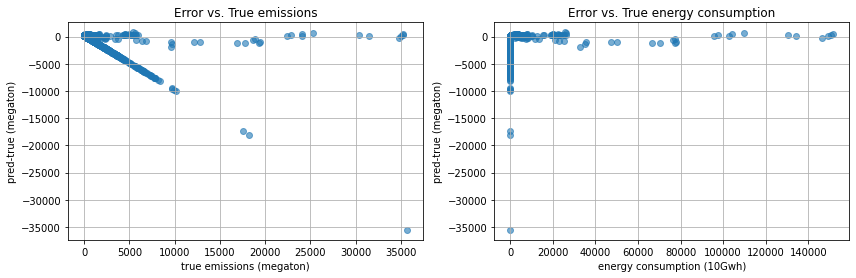

In [30]:
#plot the results
plt.figure(figsize=(14,4))

plt.subplot(121)
plt.scatter(x=y_var_1_test,y=y_var_1_pred-y_var_1_test,alpha=0.6)
plt.xlabel('true emissions (megaton)')
plt.ylabel('pred-true (megaton)')
plt.title('Error vs. True emissions')
plt.grid('on')

plt.subplot(122)
plt.scatter(x=x_var_1_test,y=y_var_1_pred-y_var_1_test,alpha=0.6)
plt.xlabel('energy consumption (10Gwh)')
plt.ylabel('pred-true (megaton)')
plt.title('Error vs. True energy consumption')
plt.grid('on')

In [31]:
# plt.figure(figsize=(8,6))
# plt.scatter(x_var_1_test, y_var_1_test, color='green', label='test_set',alpha=0.6)
# plt.plot(x_var_1_test,y_var_1_pred,color='red', label='train_result')
# plt.legend()
# plt.xlabel('Energy Consumption')
# plt.ylabel('CO2 Production')
# plt.title('Linear Regression Results')

## 2.4 Save the data 

In [32]:
# save the data to a new csv file
datapath = '../data'
save_file(co2_data_df, 'co2_data_updated.csv', datapath)

A file already exists with this name.

Do you want to overwrite? (Y/N)Y
Writing file.  "../data\co2_data_updated.csv"


In [33]:
# !!! (residue plot => feature engi.)
# !!! any insight i can gain from this porject, talk about coeff. of my model.